## Import Autophagy Package

In [26]:
# Specific imports for cellular_raza
# The package is named cr_autophagy
# We want to reload the package when some of the behind-the scenes python functions change
# This is what the importlib statements are for
import importlib
import cr_autophagy as cra
importlib.reload(cra)

# Imports of general-purpose python libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyvista as pv
import multiprocessing as mp
from pathlib import Path
import os

output_path = cra.get_last_output_path()
simulation_settings = cra.get_simulation_settings(output_path)
iter_0_particles = cra.get_particles_at_iter(output_path, 0)
for col in iter_0_particles.columns:
    print(col)

identifier
element.id
element.parent_id
element.cell.mechanics.mechanics.pos
element.cell.mechanics.mechanics.vel
element.cell.mechanics.mechanics.mass
element.cell.mechanics.mechanics.damping
element.cell.mechanics.mechanics.kb_temperature
element.cell.mechanics.mechanics.update_interval
element.cell.mechanics.mechanics.random_vector
element.cell.interaction.species
element.cell.interaction.cell_radius
element.cell.interaction.potential_strength
element.cell.interaction.interaction_range
element.cell.interaction.clustering_strength
element.cell.interaction.neighbour_count


## Read results from json Files
The results of the simulation are saved in json files.
Due to the parallelized nature of the simulation, not all results are in one big json file but rather in multiple batches. We therefore need to combine these batches to obtain a complete set for a given iteration.

We want to inspect which entries our generated dataset has. Therefore, we normalize the dict, transforming it into a dataframe.
Afterwards, we display all columns.

## Analysis
1. Determine how the Cargo size changes over the course of the simulation
2. Determine if ATG11Receptor actually clusters

In [ ]:
# TODO
gr = df[df["element.cell.interaction.species"]=="Cargo"].groupby(["iteration"])["element.cell.mechanics.mechanics.pos"]
std = np.array([[*iteration, *np.std(np.array(g), axis=0)] for (iteration, g) in gr])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16,8))

ax0.plot(std[:,0], std[:,1:], label=[f"Direction {i}" for i in range(std.shape[1]-1)])
ax0.plot(std[:,0], np.average(std[:,1:], axis=1), color="black", label="Mean Squared")
ax0.set_title("Cargo Sizes")
ax0.set_ylabel("$\\sigma$")
ax0.set_xlabel("iteration")
ax0.legend()

def calculate_displacements(x):
    y = np.vstack(x.values)
    z = np.sum((y[1:] - y[:-1])**2, axis=1)**0.5
    return z

positions = df[df["element.cell.interaction.species"]=="ATG11Receptor"].groupby(["identifier"])["element.cell.mechanics.mechanics.pos"]
dlp_mean = positions.apply(calculate_displacements).mean()
dlp_std = np.std(np.array([p for p in positions.apply(calculate_displacements).values]), axis=0)

ax1.fill_between(std[:,0][1:], dlp_mean - 0.5*dlp_std, dlp_mean + 0.5*dlp_std, color="#080808", alpha=0.2, label="Displacement Stdev")
ax1.plot(std[:,0][1:], dlp_mean, color="black", label="Displacement Mean")
ax1.legend()
ax1.set_ylabel("Displacement")
ax1.set_xlabel("iteration")

def calculate_displacement_distribution(x):
    y = np.vstack(x.values)
    z = np.concatenate(y[1:] - y[:-1])
    return z

distr = positions.apply(calculate_displacement_distribution)
n, bins, patches = ax3.hist(np.concatenate(distr.values), bins=150, label="Displacement ATG11Receptor", color="#008888")

# Fit gaussian to distribution
fit_func = lambda x, sigma, mu, a: a/(sigma*(2*np.pi)**0.5)*np.exp(-0.5*(x-mu)**2/sigma**2)
x = (bins[1:]+bins[:-1])/2
y = n
popt, _ = sp.optimize.curve_fit(fit_func, xdata=x, ydata=y)
ax3.plot(x, fit_func(x, *popt), color="red", label=f"Gaussian fit with $\sigma=${popt[0]:2.3}")
ax3.set_xlabel("")
ax3.legend()

plt.show(fig)

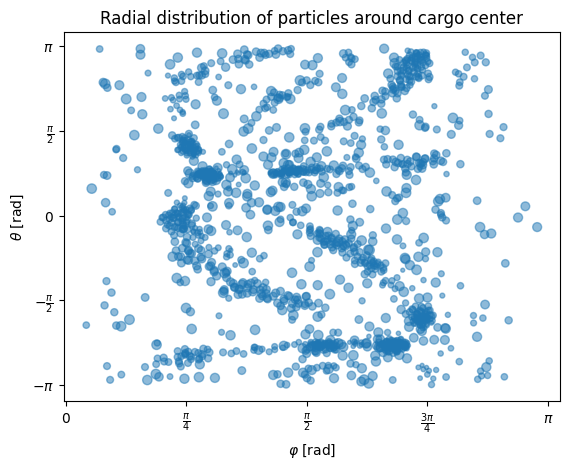

In [23]:
max_iter = max(cra.get_all_iterations(output_path))
df = cra.get_particles_at_iter(output_path, max_iter)

cargo_at_end = df[df["element.cell.interaction.species"]=="Cargo"]["element.cell.mechanics.mechanics.pos"]
cargo_at_end = np.array([np.array(elem) for elem in cargo_at_end])
non_cargo_at_end = df[df["element.cell.interaction.species"]!="Cargo"]["element.cell.mechanics.mechanics.pos"]
non_cargo_at_end = np.array([np.array(elem) for elem in non_cargo_at_end])
cargo_middle = np.average(non_cargo_at_end, axis=0)

def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

non_cargo_at_end_spherical = appendSpherical_np(non_cargo_at_end - cargo_middle)
r = non_cargo_at_end_spherical[:,3]
r_inv = np.max(r) - r
phi = non_cargo_at_end_spherical[:,4]
theta = non_cargo_at_end_spherical[:,5]

fig, ax = plt.subplots()
ax.set_title("Radial distribution of particles around cargo center")
ax.scatter(phi, theta, s=r_inv, alpha=0.5)
ax.set_xlabel("$\\varphi$ [rad]")
ax.set_ylabel("$\\theta$ [rad]")
ax.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels(["$0$", "$\\frac{\\pi}{4}$", "$\\frac{\\pi}{2}$", "$\\frac{3\\pi}{4}$", "$\\pi$"])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(["$-\\pi$", "$-\\frac{\\pi}{2}$", "$0$", "$\\frac{\\pi}{2}$", "$\\pi$"])
plt.show(fig)

## Plot Result
We visualize the results in 3D.
Therefore we use `pyvista` which internally uses `vtk` as a backend.
Since all of our particles are represented as 3D-spheres, we also display them as such.

In [15]:
import pyvista as pv
import numpy as np
import multiprocessing as mp
from pathlib import Path
import os

def generate_spheres(iteration):
    # Filter for only particles at the specified iteration
    df = cra.get_particles_at_iter(output_path, iteration)
    # df = df[df["iteration"]==iteration]

    # Create a dataset for pyvista for plotting
    pset = pv.PolyData(np.array([np.array(x) for x in df["element.cell.mechanics.mechanics.pos"]]))

    # Extend dataset by species and diameter
    pset.point_data["diameter"] = 2.0*df["element.cell.interaction.cell_radius"]
    pset.point_data["species"] = df["element.cell.interaction.species"]

    # Create spheres glyphs from dataset
    sphere = pv.Sphere()
    spheres = pset.glyph(geom=sphere, scale="diameter", orient=False)

    return spheres

def save_snapshot(iteration):
    opath = Path(output_path) / "snapshot_{:08}.png".format(iteration)
    if os.path.isfile(opath):
        return
    spheres = generate_spheres(iteration)

    spheres.plot(
        off_screen=True,
        screenshot=opath,
        scalars="species",
        scalar_bar_args={
            "title":"Species",
        },
        cpos=[
            (
                -1.5*simulation_settings.domain_size,
                -1.5*simulation_settings.domain_size,
                -1.5*simulation_settings.domain_size
            ),(
                25,
                25,
                25
            ),(
                0.0,
                0.0,
                0.0
            )
        ],
        jupyter_backend='none',
    )

We can save single snapshots or even use all processes of our device to save snapshots for every iteration.
The 2nd approach will take up all resources by default. If you want to limit this, have a look at the [Pool object of the multiprocessing](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool) module.

In [24]:
# Save all snapshots
with mp.Pool() as p:
    p.map(save_snapshot, cra.get_all_iterations(output_path))

In [25]:
# Also create a movie with ffmpeg
bashcmd = f"ffmpeg -y -r 30 -f image2 -pattern_type glob -i '{output_path}/*.png' -c:v h264 -pix_fmt yuv420p -strict -2 {output_path}/amovie_4.mp4"
os.system(bashcmd)

ffmpeg version n6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13.2.1 (GCC) 20230801
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpl --enable-libvpx --enable-libwebp --enable-libx264 --enable

0